In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle/'

In [ ]:
import zipfile

file_path = '/content/skin-cancer-malignant-vs-benign.zip'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/kaggle')

In [2]:
!pip install scikit-plot

In [11]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc
from sklearn.preprocessing import LabelEncoder

In [12]:
EPOCHS = 15
# 16, 32, 64
BATCH_SIZE = 32
SEED = 42
TF_SEED = 768
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
IMAGE_SIZE = (224, 224, 3)

In [13]:
DATASET_PATH = '/content/drive/MyDrive/kaggle/data/'
TRAIN_PATH = os.path.join(DATASET_PATH, "train/")
TEST_PATH = os.path.join(DATASET_PATH, "test/")

In [14]:
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in /content/drive/MyDrive/kaggle/data/
There are 2 directories and 0 images in /content/drive/MyDrive/kaggle/data/test
There are 0 directories and 360 images in /content/drive/MyDrive/kaggle/data/test/benign
There are 0 directories and 300 images in /content/drive/MyDrive/kaggle/data/test/malignant
There are 2 directories and 0 images in /content/drive/MyDrive/kaggle/data/train
There are 0 directories and 1440 images in /content/drive/MyDrive/kaggle/data/train/benign
There are 0 directories and 1197 images in /content/drive/MyDrive/kaggle/data/train/malignant


In [15]:
train_bn_dir = os.path.join(TRAIN_PATH,"benign/")
train_ma_dir = os.path.join(TRAIN_PATH,"malignant/")
test_bn_dir = os.path.join(TEST_PATH,"benign/")
test_ma_dir = os.path.join(TEST_PATH,"malignant/")

In [16]:
print('total training benign images:', len(os.listdir(train_bn_dir)))
print('total training malignant images:', len(os.listdir(train_ma_dir)))

print('total testing benign images:', len(os.listdir(test_bn_dir)))
print('total testing malignant  images:', len(os.listdir(test_ma_dir)))

total training benign images: 1440
total training malignant images: 1197
total testing benign images: 360
total testing malignant  images: 300


In [17]:
num_train_bn =  len(os.listdir(train_bn_dir))
num_train_ma =  len(os.listdir(train_ma_dir))

num_test_bn =  len(os.listdir(test_bn_dir))
num_test_ma =  len(os.listdir(test_ma_dir))

total_train =num_train_bn  + num_train_ma
# total_val = num_val_i  + num_val_ni
total_test = num_test_bn   + num_test_ma

print("-----------------------------------------------------")
print("Total training images:", total_train)
# print("Total validation images:", total_val)
print("Total testing images:", total_test)

-----------------------------------------------------
Total training images: 2637
Total testing images: 660


In [18]:
def build_df(directory, label_text, label_encoded):
    image_paths = []
    labels_text = []
    labels_encoded = []
    for image in os.listdir(directory):
        image_paths.append(os.path.join(directory, image))
        labels_text.append(label_text)
        labels_encoded.append(label_encoded)
    return image_paths, labels_text, labels_encoded


train_bn_paths, train_bn_labels_text, train_bn_labels_encoded = build_df(train_bn_dir, 'benign', 0)
train_ma_paths, train_ma_labels_text, train_ma_labels_encoded = build_df(train_ma_dir, 'malignant', 1)

test_bn_paths, test_bn_labels_text, test_bn_labels_encoded = build_df(test_bn_dir, 'benign', 0)
test_ma_paths, test_ma_labels_text, test_ma_labels_encoded = build_df(test_ma_dir, 'malignant', 1)


train_df = pd.DataFrame({
    'image_path': train_bn_paths + train_ma_paths,
    'label': train_bn_labels_text + train_ma_labels_text,
    'label_encoded': train_bn_labels_encoded + train_ma_labels_encoded
})

test_df = pd.DataFrame({
    'image_path': test_bn_paths + test_ma_paths,
    'label': test_bn_labels_text + test_ma_labels_text,
    'label_encoded': test_bn_labels_encoded + test_ma_labels_encoded
})



In [19]:
train_df

image_path      label  \
0     /content/drive/MyDrive/kaggle/data/train/benig...     benign   
1     /content/drive/MyDrive/kaggle/data/train/benig...     benign   
2     /content/drive/MyDrive/kaggle/data/train/benig...     benign   
3     /content/drive/MyDrive/kaggle/data/train/benig...     benign   
4     /content/drive/MyDrive/kaggle/data/train/benig...     benign   
...                                                 ...        ...   
2632  /content/drive/MyDrive/kaggle/data/train/malig...  malignant   
2633  /content/drive/MyDrive/kaggle/data/train/malig...  malignant   
2634  /content/drive/MyDrive/kaggle/data/train/malig...  malignant   
2635  /content/drive/MyDrive/kaggle/data/train/malig...  malignant   
2636  /content/drive/MyDrive/kaggle/data/train/malig...  malignant   

      label_encoded  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
2632              1  
2633              1  
2634              1  
2635              1  
2636              1  

[2637 rows x 3 columns]

In [20]:
test_df

image_path      label  \
0    /content/drive/MyDrive/kaggle/data/test/benign...     benign   
1    /content/drive/MyDrive/kaggle/data/test/benign...     benign   
2    /content/drive/MyDrive/kaggle/data/test/benign...     benign   
3    /content/drive/MyDrive/kaggle/data/test/benign...     benign   
4    /content/drive/MyDrive/kaggle/data/test/benign...     benign   
..                                                 ...        ...   
655  /content/drive/MyDrive/kaggle/data/test/malign...  malignant   
656  /content/drive/MyDrive/kaggle/data/test/malign...  malignant   
657  /content/drive/MyDrive/kaggle/data/test/malign...  malignant   
658  /content/drive/MyDrive/kaggle/data/test/malign...  malignant   
659  /content/drive/MyDrive/kaggle/data/test/malign...  malignant   

     label_encoded  
0                0  
1                0  
2                0  
3                0  
4                0  
..             ...  
655              1  
656              1  
657              1  
658              1  
659              1  

[660 rows x 3 columns]

In [21]:
def _load(image_path):

    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [HEIGHT, WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS3)
    image = tf.cast(image, tf.float32)/255.
    return image

def view_sample(image, label, color_map='rgb', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)

    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(tf.image.rgb_to_grayscale(image), cmap=color_map)

    plt.title(f'Label: {label}', fontsize=16)
    return

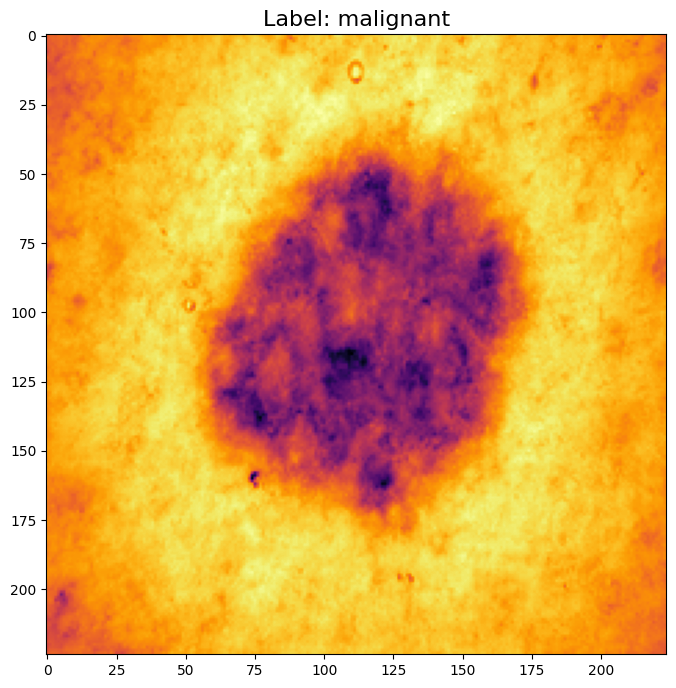

In [22]:
idx = random.sample(train_df.index.to_list(), 1)[0]
sample_image, sample_label = _load(train_df.image_path[idx]), train_df.label[idx]
view_sample(sample_image, sample_label, color_map='inferno')

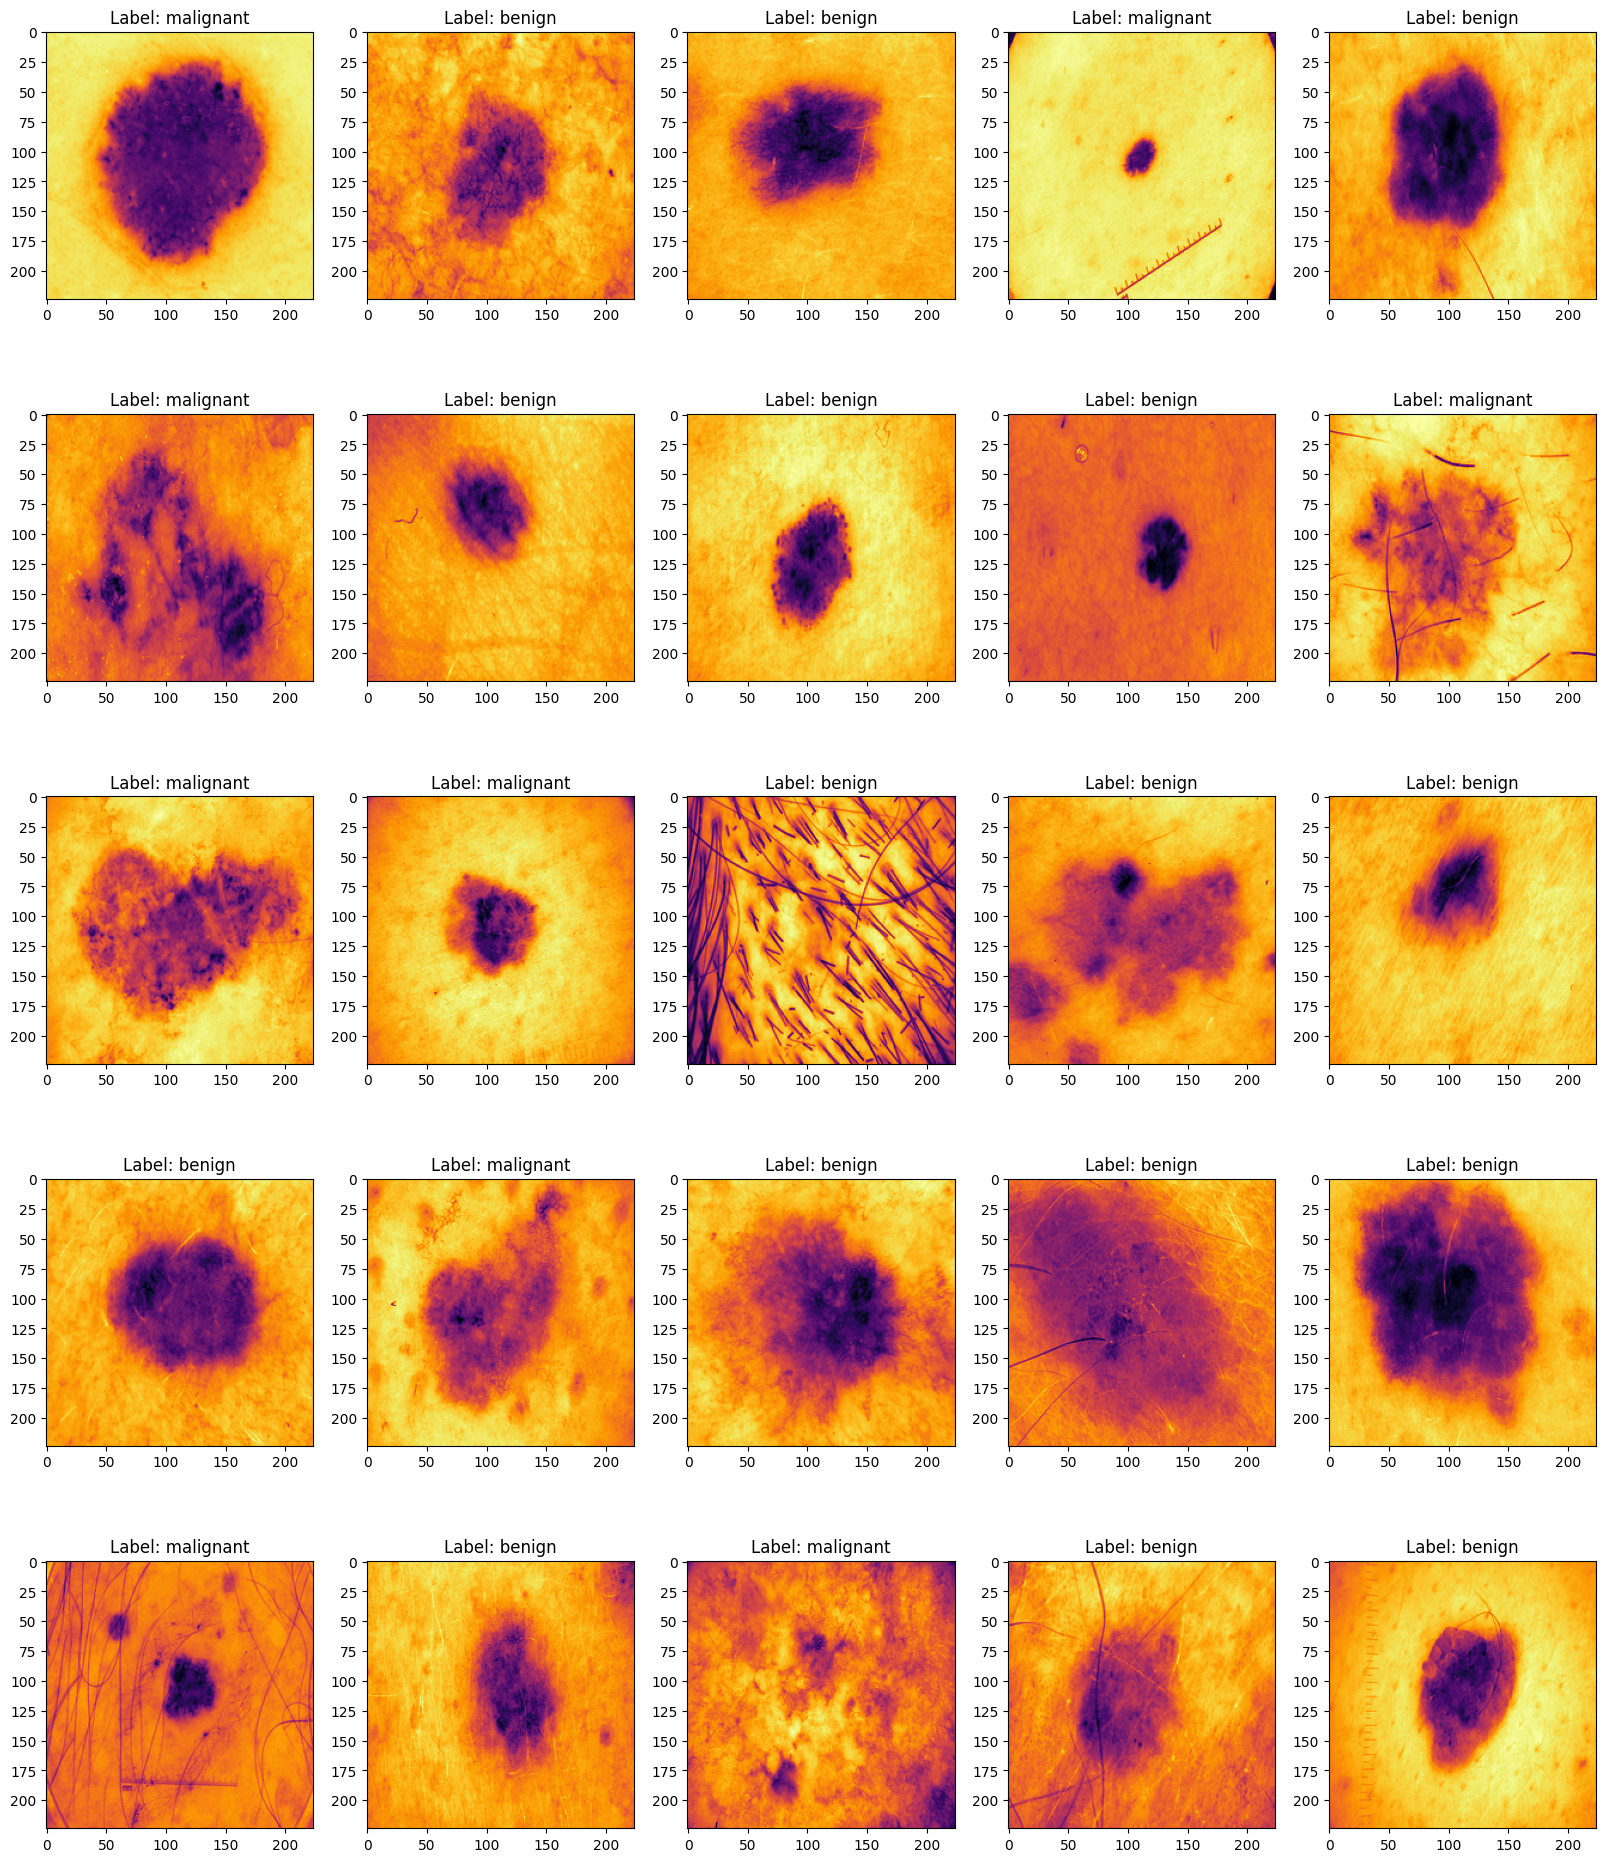

In [23]:
def view_mulitiple_samples(df, sample_loader, count=10, color_map='inferno', fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1

    idx = random.sample(df.index.to_list(), count)
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}')

        if color_map=='rgb':
            plt.imshow(sample_loader(df.image_path[_]))
        else:
            plt.imshow(tf.image.rgb_to_grayscale(sample_loader(df.image_path[_])), cmap=color_map)

    return

view_mulitiple_samples(train_df, _load,
                       count=25, color_map='inferno',
                       fig_size=(20, 24))

In [24]:
train_split_idx, val_split_idx, _, _ = train_test_split(train_df.index,
                                                        train_df.label_encoded,
                                                        test_size=0.15,
                                                        stratify=train_df.label_encoded,
                                                        random_state=SEED)

In [25]:
train_new_df = train_df.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df.iloc[val_split_idx].reset_index(drop=True)
train_new_df.shape, val_df.shape

((2241, 3), (396, 3))

In [26]:
val_df

image_path      label  \
0    /content/drive/MyDrive/kaggle/data/train/benig...     benign   
1    /content/drive/MyDrive/kaggle/data/train/benig...     benign   
2    /content/drive/MyDrive/kaggle/data/train/benig...     benign   
3    /content/drive/MyDrive/kaggle/data/train/benig...     benign   
4    /content/drive/MyDrive/kaggle/data/train/benig...     benign   
..                                                 ...        ...   
391  /content/drive/MyDrive/kaggle/data/train/malig...  malignant   
392  /content/drive/MyDrive/kaggle/data/train/benig...     benign   
393  /content/drive/MyDrive/kaggle/data/train/malig...  malignant   
394  /content/drive/MyDrive/kaggle/data/train/benig...     benign   
395  /content/drive/MyDrive/kaggle/data/train/benig...     benign   

     label_encoded  
0                0  
1                0  
2                0  
3                0  
4                0  
..             ...  
391              1  
392              0  
393              1  
394              0  
395              0  

[396 rows x 3 columns]

In [27]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [28]:
train_ds = train_datagen.flow_from_dataframe(
    dataframe=train_new_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE
    # class_mode='binary'
)

val_ds = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE
    # class_mode='binary'
)

test_ds = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    # class_mode='binary',
    shuffle=False
)

Found 2241 validated image filenames belonging to 2 classes.
Found 396 validated image filenames belonging to 2 classes.
Found 660 validated image filenames belonging to 2 classes.


In [29]:
def cnn_model():

    initializer = tf.keras.initializers.GlorotNormal()

    cnn_sequential = Sequential([
        layers.Input(shape=IMAGE_SIZE, dtype=tf.float32, name='input_image'),

        layers.Conv2D(16, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(16, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2, padding='valid'),

        layers.Conv2D(8, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(8, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2),

        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(2, activation='sigmoid', kernel_initializer=initializer)
    ], name='cnn_sequential_model')

    return cnn_sequential

In [30]:
model_cnn = cnn_model()
model_cnn.summary()

Model: "cnn_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 16)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 8)       1160      
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 8)       584       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 8)         0         
 g2D)                                         

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


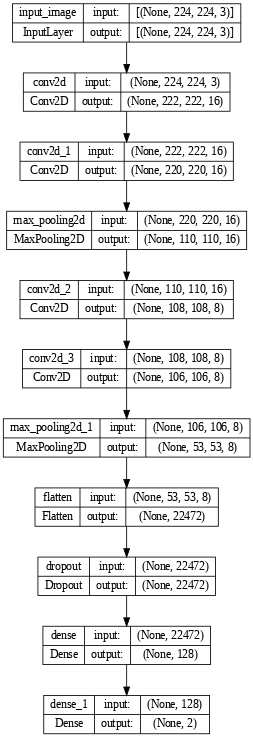

In [31]:
plot_model(
    model_cnn, dpi=60,
    show_shapes=True
)

In [32]:
def train_model(model, num_epochs, callbacks_list, tf_train_data,
                tf_valid_data=None, shuffling=False):

    model_history = {}

    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)

    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

In [37]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)


reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1)


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/kaggle/final_model_efficientnet.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1)


CALLBACKS = [early_stopping_callback, reduce_lr_callback, model_checkpoint_callback]
METRICS = ['accuracy']

In [34]:
tf.random.set_seed(SEED)

model_cnn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

print(f'Training {model_cnn.name}.')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

cnn_history = train_model(
    model_cnn, EPOCHS, CALLBACKS,
    train_ds, val_ds,
    shuffling=False
)

Training cnn_sequential_model.
Train on 2241 samples, validate on 396 samples.
----------------------------------
Epoch 1/15
71/71 [==============================] - ETA: 0s - loss: 0.5856 - accuracy: 0.6823
Epoch 1: val_loss improved from inf to 0.48890, saving model to /content/drive/MyDrive/kaggle/final_model_cnn.h5
71/71 [==============================] - 339s 5s/step - loss: 0.5856 - accuracy: 0.6823 - val_loss: 0.4889 - val_accuracy: 0.7298 - lr: 0.0010
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/71 [============================>.] - ETA: 0s - loss: 0.5880 - accuracy: 0.6857
Epoch 2: val_loss improved from 0.48890 to 0.48594, saving model to /content/drive/MyDrive/kaggle/final_model_cnn.h5
71/71 [==============================] - 29s 404ms/step - loss: 0.5878 - accuracy: 0.6859 - val_loss: 0.4859 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 3/15
70/71 [============================>.] - ETA: 0s - loss: 0.4674 - accuracy: 0.7692
Epoch 3: val_loss did not improve from 0.48594
71/71 [==============================] - 28s 396ms/step - loss: 0.4678 - accuracy: 0.7689 - val_loss: 0.4940 - val_accuracy: 0.7197 - lr: 0.0010
Epoch 4/15
70/71 [============================>.] - ETA: 0s - loss: 0.5004 - accuracy: 0.7500
Epoch 4: val_loss did not improve from 0.48594
71/71 [==============================] - 28s 394ms/step - loss: 0.5004 - accuracy: 0.7501 - val_loss: 0.6597 - val_accuracy: 0.6995 - lr: 0.0010
Epoch 5/15
70/71 [============================>.] - ETA: 0s - loss: 0.5974 - accura

In [35]:
cnn_evaluation = model_cnn.evaluate(test_ds)

21/21 [==============================] - 160s 8s/step - loss: 0.3647 - accuracy: 0.7909


In [36]:
cnn_test_probabilities = model_cnn.predict(test_ds, verbose=1)
cnn_test_predictions = tf.argmax(cnn_test_probabilities, axis=1)

21/21 [==============================] - 2s 80ms/step


EfficientNet


In [38]:
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [39]:
efficientnet_v2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2'
model_name = 'efficientnet_v2_b0'

set_trainable=False

efficientnet_v2_b0 = get_tfhub_model(efficientnet_v2_url,
                                     model_name,
                                     model_trainable=set_trainable)

In [40]:
def efficientnet_v2_model():

    initializer = tf.keras.initializers.GlorotNormal()

    efficientnet_v2_sequential = Sequential([
        layers.Input(shape=IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        efficientnet_v2_b0,
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(2, dtype=tf.float32, activation='sigmoid', kernel_initializer=initializer)
    ], name='efficientnet_v2_sequential_model')

    return efficientnet_v2_sequential

In [41]:
model_efficientnet_v2 = efficientnet_v2_model()

model_efficientnet_v2.summary()

Model: "efficientnet_v2_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet_v2_b0 (KerasL  (None, 1280)              5919312   
 ayer)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 6083538 (23.21 MB)
Trainable params: 164226 (641.51 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [42]:
tf.random.set_seed(SEED)

model_efficientnet_v2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

print(f'Training {model_efficientnet_v2.name}.')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

efficientnet_v2_history = train_model(
    model_efficientnet_v2, EPOCHS, CALLBACKS,
    train_ds, val_ds,
    shuffling=False
)

Training efficientnet_v2_sequential_model.
Train on 2241 samples, validate on 396 samples.
----------------------------------
Epoch 1/15
71/71 [==============================] - ETA: 0s - loss: 0.4465 - accuracy: 0.8032
Epoch 1: val_loss improved from inf to 0.41088, saving model to /content/drive/MyDrive/kaggle/final_model_efficientnet.h5
71/71 [==============================] - 38s 431ms/step - loss: 0.4465 - accuracy: 0.8032 - val_loss: 0.4109 - val_accuracy: 0.7980 - lr: 0.0010
Epoch 2/15
70/71 [============================>.] - ETA: 0s - loss: 0.3348 - accuracy: 0.8473
Epoch 2: val_loss improved from 0.41088 to 0.31121, saving model to /content/drive/MyDrive/kaggle/final_model_efficientnet.h5
71/71 [==============================] - 29s 406ms/step - loss: 0.3353 - accuracy: 0.8469 - val_loss: 0.3112 - val_accuracy: 0.8611 - lr: 0.0010
Epoch 3/15
70/71 [============================>.] - ETA: 0s - loss: 0.3252 - accuracy: 0.8576
Epoch 3: val_loss did not improve from 0.31121
71/71 [

In [71]:
efficientnet_v2_evaluation = model_efficientnet_v2.evaluate(test_ds)

21/21 [==============================] - 4s 150ms/step - loss: 0.2976 - accuracy: 0.8667


In [72]:
efficientnet_v2_test_probabilities = model_efficientnet_v2.predict(test_ds, verbose=1)
efficientnet_v2_test_predictions = tf.argmax(efficientnet_v2_test_probabilities, axis=1)

21/21 [==============================] - 3s 91ms/step


In [43]:
!pip install -q vit-keras

In [45]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.6 MB/s eta 0:00:00


In [46]:
from vit_keras import vit
vit_model = vit.vit_b16(
    image_size=224,
    activation='sigmoid',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=2
)
for layer in vit_model.layers:
    layer.trainable = False

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


347502902/347502902 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [47]:
def vit_b16_model():

    initializer = tf.keras.initializers.GlorotNormal()

    vit_b16_sequential = Sequential([
        layers.Input(shape=IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        vit_model,
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(2, dtype=tf.float32, activation='sigmoid', kernel_initializer=initializer)
    ], name='vit_b16_sequential_model')

    return vit_b16_sequential

In [48]:
model_vit_b16 = vit_b16_model()
model_vit_b16.summary()

Model: "vit_b16_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout_2 (Dropout)         (None, 768)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               98432     
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 85897346 (327.67 MB)
Trainable params: 98690 (385.51 KB)
Non-trainable params: 85798656 (327.30 MB)
_________________________________________________________________


In [49]:
tf.random.set_seed(SEED)
model_vit_b16.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)
print(f'Training {model_vit_b16.name}.')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

vit_b16_history = train_model(
    model_vit_b16, EPOCHS, CALLBACKS,
    train_ds, val_ds,
    shuffling=False
)

Training vit_b16_sequential_model.
Train on 2241 samples, validate on 396 samples.
----------------------------------
Epoch 1/15
70/71 [============================>.] - ETA: 0s - loss: 0.4159 - accuracy: 0.8183
Epoch 1: val_loss did not improve from 0.29797
71/71 [==============================] - 55s 601ms/step - loss: 0.4158 - accuracy: 0.8184 - val_loss: 0.5621 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 2/15
70/71 [============================>.] - ETA: 0s - loss: 0.3282 - accuracy: 0.8531
Epoch 2: val_loss did not improve from 0.29797
71/71 [==============================] - 39s 549ms/step - loss: 0.3285 - accuracy: 0.8527 - val_loss: 0.4809 - val_accuracy: 0.7929 - lr: 0.0010
Epoch 3/15
70/71 [============================>.] - ETA: 0s - loss: 0.3162 - accuracy: 0.8554
Epoch 3: val_loss did not improve from 0.29797
71/71 [==============================] - 39s 551ms/step - loss: 0.3161 - accuracy: 0.8554 - val_loss: 0.3687 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 4/15
70/71 [======

In [50]:
vit_b16_evaluation = model_vit_b16.evaluate(test_ds)

21/21 [==============================] - 9s 425ms/step - loss: 0.3121 - accuracy: 0.8606


In [51]:
vit_b16_test_probabilities = model_vit_b16.predict(test_ds, verbose=1)
vit_b16_test_predictions = tf.argmax(vit_b16_test_probabilities, axis=1)

21/21 [==============================] - 12s 433ms/step


In [53]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Extracting loss and accuracy values for both training and validation sets
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Creating subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plotting training and validation loss
    axes[0].plot(train_loss, label='Training Loss')
    axes[0].plot(val_loss, label='Validation Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Plotting training and validation accuracy
    axes[1].plot(train_accuracy, label='Training Accuracy')
    axes[1].plot(val_accuracy, label='Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

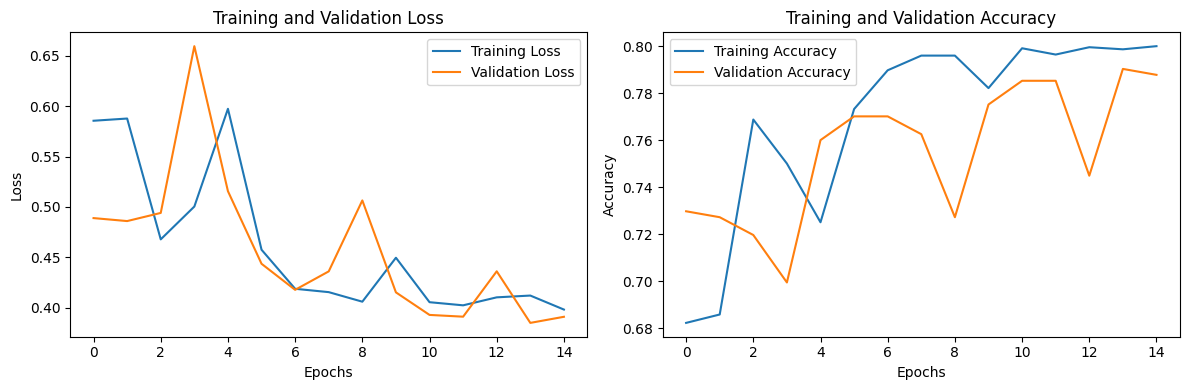

In [55]:
plot_training_history(cnn_history)

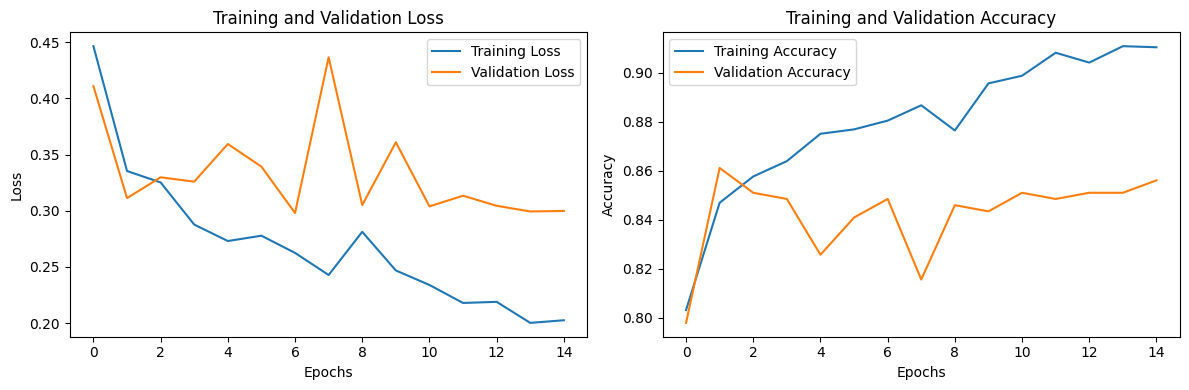

In [56]:
plot_training_history(efficientnet_v2_history)

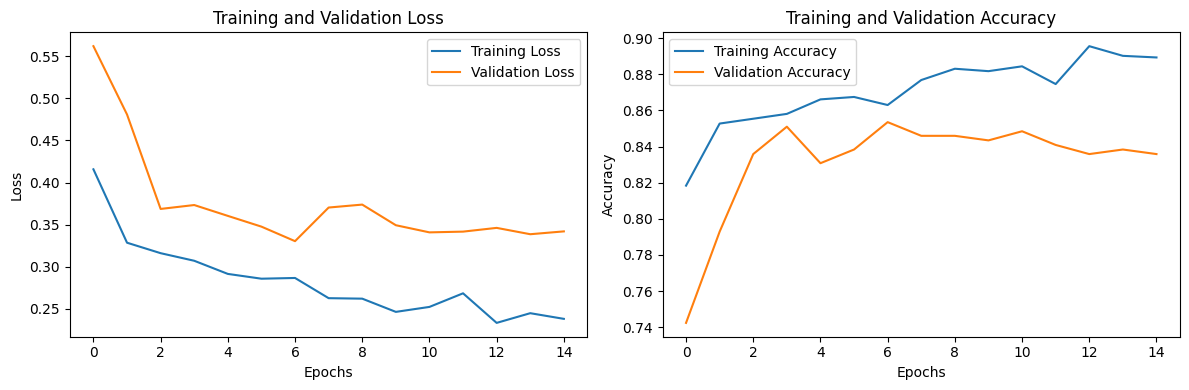

In [57]:
plot_training_history(vit_b16_history)

In [76]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    disp = sns.heatmap(
        cm, annot=True, cmap='Blues',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20)
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)
    plt.show()

    return

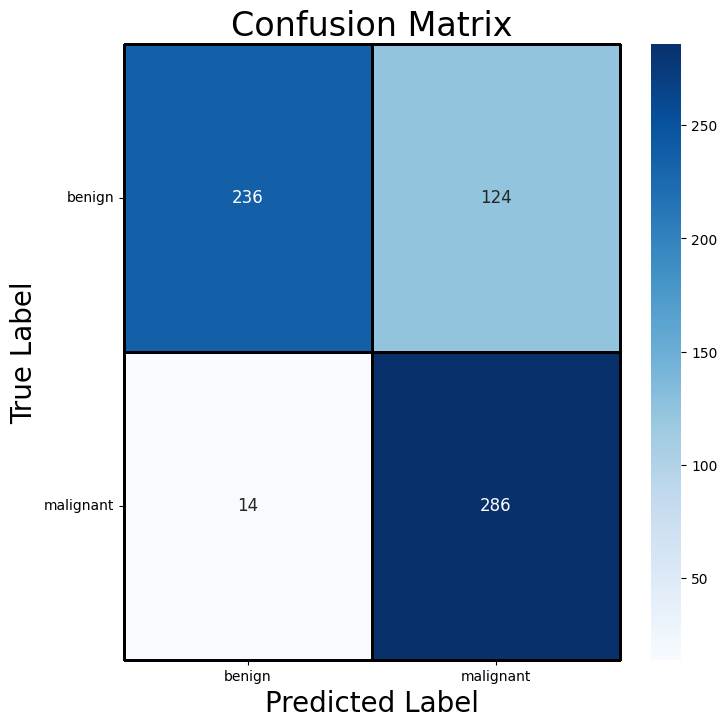

In [77]:
class_names = ['benign','malignant']

plot_confusion_matrix(
    test_df.label_encoded,
    cnn_test_predictions,
    figsize=(8, 8),
    classes=class_names)

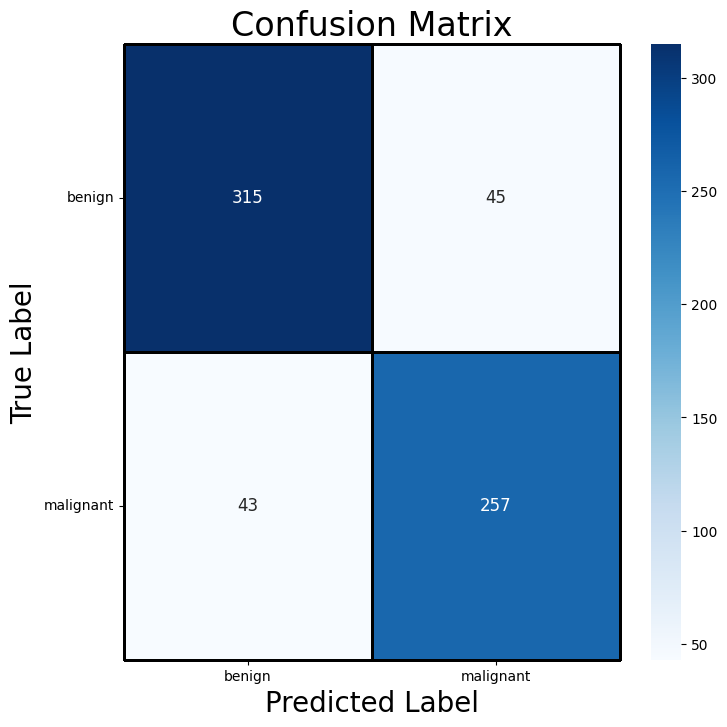

In [78]:
plot_confusion_matrix(
    test_df.label_encoded,
    efficientnet_v2_test_predictions,
    figsize=(8, 8),
    classes=class_names)

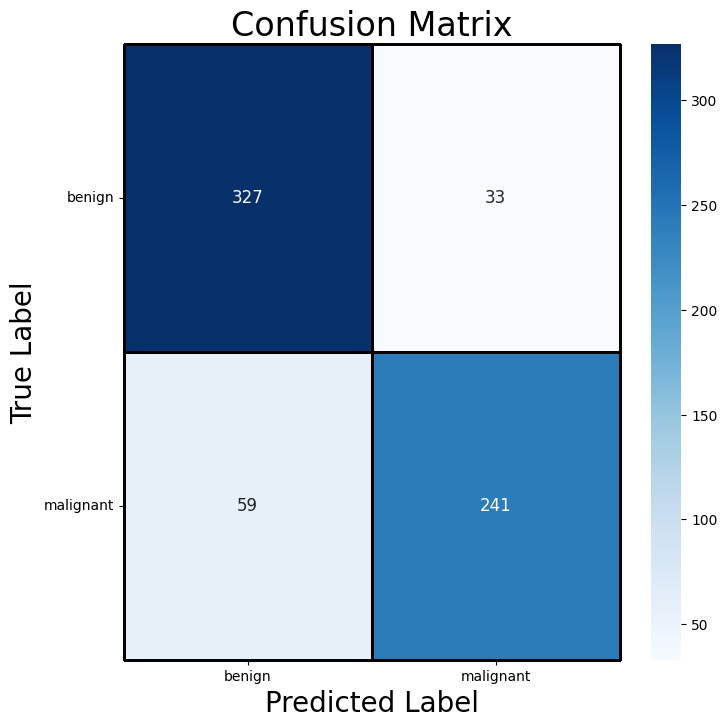

In [79]:
plot_confusion_matrix(
    test_df.label_encoded,
    vit_b16_test_predictions,
    figsize=(8, 8),
    classes=class_names)

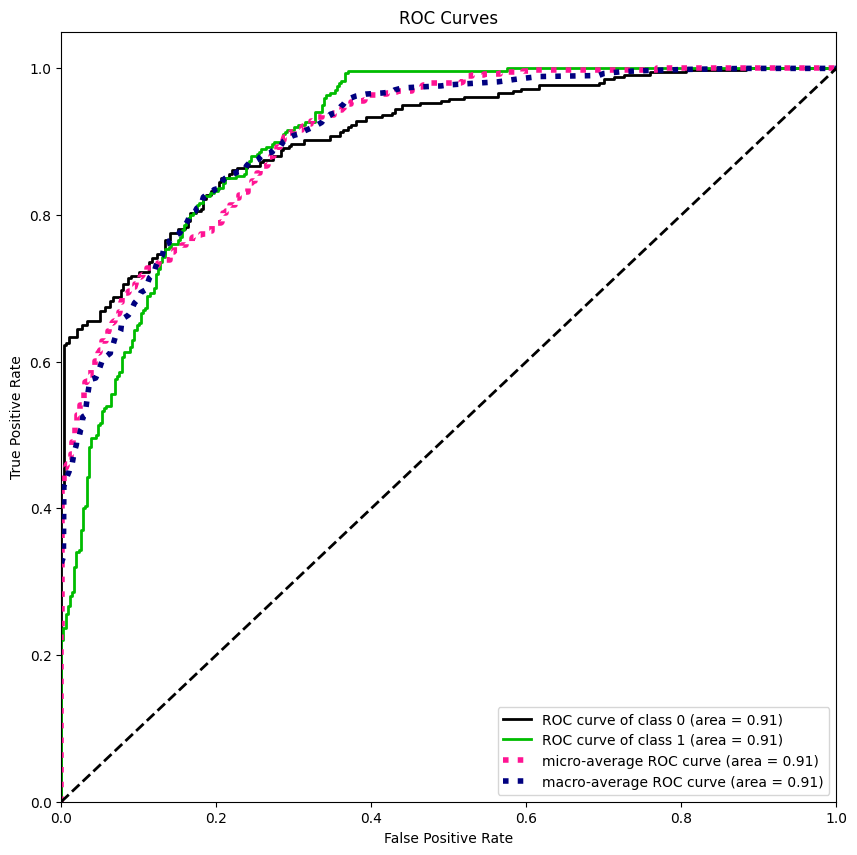

In [80]:
plot_roc(test_df.label_encoded,
         cnn_test_probabilities,
         figsize=(10, 10), title_fontsize='large');

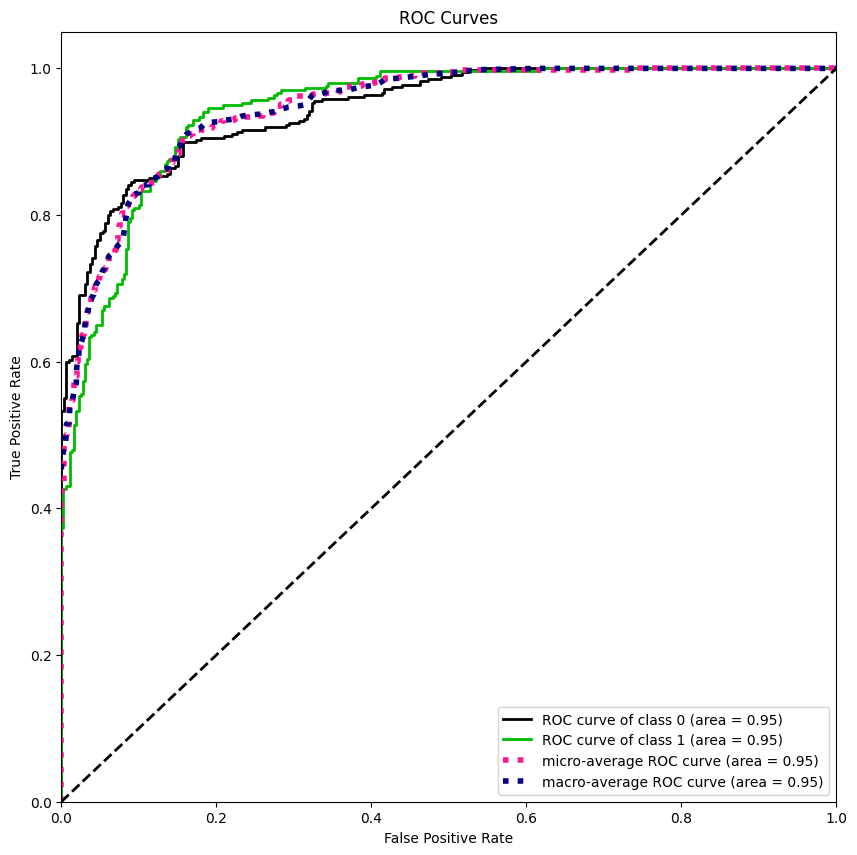

In [81]:
plot_roc(test_df.label_encoded,
         efficientnet_v2_test_probabilities,
         figsize=(10, 10), title_fontsize='large');

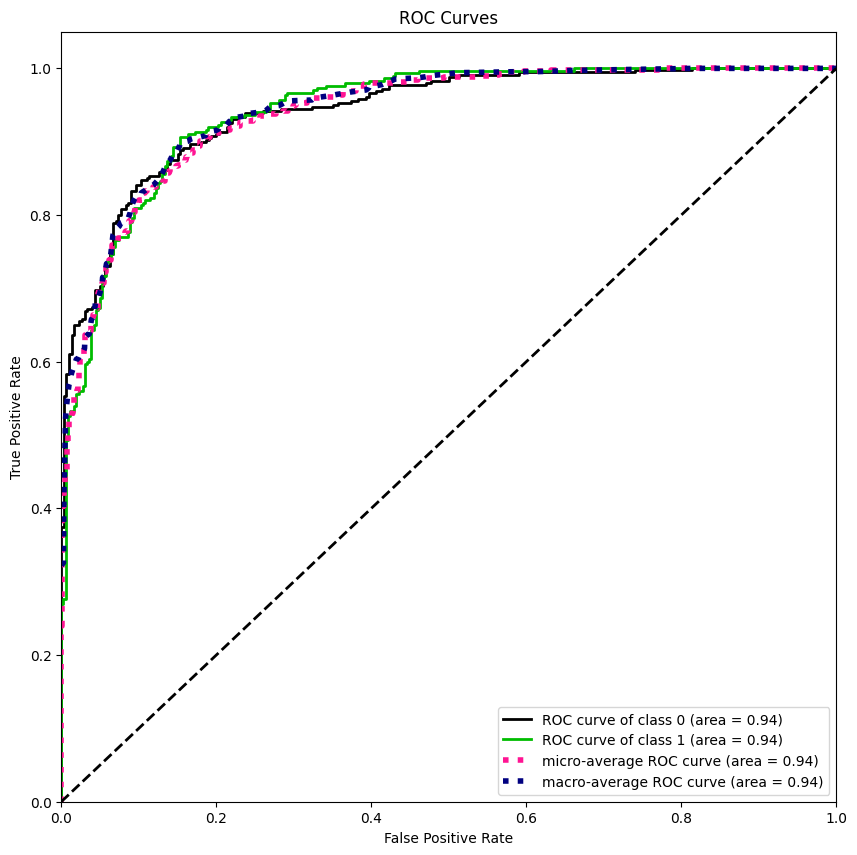

In [82]:
plot_roc(test_df.label_encoded,
         vit_b16_test_probabilities,
         figsize=(10, 10), title_fontsize='large');